In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import wandb
from tqdm import tqdm
from stable_baselines3 import SAC
from stable_baselines3.common.preprocessing import get_action_dim

from env import PathFollowingEnv

from torch.cuda.amp import autocast, GradScaler
import math
import pandas as pd
from datetime import datetime

class ExpertDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.FloatTensor(observations)
        self.actions = torch.FloatTensor(actions)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        return self.observations[idx], self.actions[idx]

def generate_expert_data(env, n_episodes=1000, save_dir="expert_demonstrations"):
    """Generate expert demonstrations and save to CSV files"""
    
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    csv_file = os.path.join(save_dir, f'expert_data_{timestamp}.csv')
    
    columns = [
        'episode', 'step', 'success',
        'current_x', 'current_y',
        'goal_x', 'goal_y'
    ]
    for i in range(env.chunk_size):
        columns.extend([f'waypoint_{i}_x', f'waypoint_{i}_y'])
    columns.extend(['distance_to_goal', 'distance_to_next', 'timestep',
                   'action_linear', 'action_angular'])
    
    # Write header to CSV
    df = pd.DataFrame(columns=columns)
    df.to_csv(csv_file, index=False, header=True)
    
    successful_episodes = 0
    thresh = 0.1
    
    episode_pbar = tqdm(total=n_episodes, desc="Generating episodes", position=0)
    success_pbar = tqdm(total=n_episodes, desc="Successful episodes", position=1)
    
    try:
        for episode in range(n_episodes):
            episode_data = []
            
            obs = env.reset()[0]
            done = False
            truncated = False
            
            path = env.path_manager.get_full_path()
            
            # Skip if path is empty or too short
            if path is None or len(path) < 2:
                episode_pbar.update(1)
                continue
                
            current_pos = env.current_pos
            current_theta = env.agent_theta
            episode_success = False
            
            # Path following progress bar
            path_pbar = tqdm(total=len(path)-1, desc="Following path", 
                           position=2, leave=False)
            
            i = 0
            while i < (len(path) - 1):
                current_waypoint = path[i]
                distance = np.linalg.norm(current_waypoint - current_pos)

                if distance < thresh:
                    i += 1
                    path_pbar.update(1)
                    continue
                
                # Calculate expert action
                dx = current_waypoint[0] - current_pos[0]
                dy = current_waypoint[1] - current_pos[1]
                desired_theta = (np.arctan2(dy, dx) + np.pi) % (2 * np.pi) - np.pi
                
                angle_diff = desired_theta - current_theta
                angle_diff = (angle_diff + np.pi) % (2 * np.pi) - np.pi
                
                # Generate expert action
                l = min(distance, 1.0) if abs(angle_diff) < np.pi/4 else 0.0
                theta = np.clip(angle_diff / np.pi, -1.0, 1.0)
                
                action = np.array([l, theta])
                
                # Store step data
                row = {
                    'episode': successful_episodes,
                    'step': env.current_step,
                    'success': False,  # Will update later if successful
                    'current_x': obs[0],
                    'current_y': obs[1],
                    'goal_x': obs[2],
                    'goal_y': obs[3],
                }
                
                # Add waypoints
                for j in range(env.chunk_size):
                    if 4 + j*2 + 1 < len(obs):  # Check if waypoint exists in observation
                        row[f'waypoint_{j}_x'] = obs[4 + j*2]
                        row[f'waypoint_{j}_y'] = obs[4 + j*2 + 1]
                    else:
                        row[f'waypoint_{j}_x'] = obs[-6]  # Use last valid waypoint
                        row[f'waypoint_{j}_y'] = obs[-5]
                
                # Add metrics
                row.update({
                    'distance_to_goal': obs[-3],
                    'distance_to_next': obs[-2],
                    'timestep': obs[-1],
                    'action_linear': action[0],
                    'action_angular': action[1]
                })
                
                episode_data.append(row)
                
                # Update environment
                obs, reward, done, truncated, info = env.step(action)
                
                if done or truncated:
                    episode_success = done
                    break
                    
                current_pos = env.current_pos
                current_theta = env.agent_theta
                path_pbar.update(1)
            
            path_pbar.close()
            
            # If episode completed successfully, save it
            if len(episode_data) > 0:
                # Update success flag for all steps in episode
                for step_data in episode_data:
                    step_data['success'] = True
                
                # Append to CSV file
                df = pd.DataFrame(episode_data)
                df.to_csv(csv_file, mode='a', header=False, index=False)
                
                successful_episodes += 1
                success_pbar.update(1)
                
                # Update progress bar postfix with stats
                success_pbar.set_postfix({
                    'len': len(episode_data),
                    'dist': f"{episode_data[-1]['distance_to_goal']:.3f}"
                })
            
            episode_pbar.update(1)
            episode_pbar.set_postfix({'success_rate': f"{successful_episodes/episode_pbar.n:.2%}"})
            
    finally:
        # Clean up progress bars
        episode_pbar.close()
        success_pbar.close()
    
    return csv_file

In [3]:
def load_demonstrations(csv_file, env):
    """Load demonstrations from single CSV file"""
    world_max = np.array([8, 6])
    world_limits = np.array([[-8, 8], [-6, 6]])
    world_diag = np.linalg.norm(world_max)
    max_episode_timesteps = 200

    print(f"Loading demonstrations from {csv_file}")
    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Filter successful episodes only
    df = df[df['success'] == True]

    df['current_x'] = df['current_x'] / world_max[0]
    df['current_y'] = df['current_y'] / world_max[1]
    df['goal_x'] = df['goal_x'] / world_max[0]
    df['goal_y'] = df['goal_y'] / world_max[1]
    for i in range(env.chunk_size):
        df[f'waypoint_{i}_x'] = df[f'waypoint_{i}_x'] / world_max[0]
        df[f'waypoint_{i}_y'] = df[f'waypoint_{i}_y'] / world_max[1]
    df['distance_to_goal'] = df['distance_to_goal'] / world_diag
    df['distance_to_next'] = df['distance_to_next'] / world_diag
    df['timestep'] = df['timestep'] / max_episode_timesteps

    # print(df.head())
    # Extract observations
    obs_cols = (
        ['current_x', 'current_y', 'goal_x', 'goal_y'] +
        [f'waypoint_{i}_x' for i in range(env.chunk_size)] +
        [f'waypoint_{i}_y' for i in range(env.chunk_size)] +
        ['distance_to_goal', 'distance_to_next', 'timestep']
    )
    
    # Extract actions
    action_cols = ['action_linear', 'action_angular']
    
    observations = df[obs_cols].values
    actions = df[action_cols].values
    
    return observations, actions

In [4]:
# if __name__ == "__main__":
#     env = PathFollowingEnv(
#         image_path="standalone_examples/api/omni.isaac.kit/TEST_FILES/New_WR_World.png",
#         algo="SAC",
#         max_episode_steps=1000,
#         headless=True
#     )
    
#     # Generate demonstrations
#     csv_file = generate_expert_data(env, n_episodes=int(1e6), save_dir="/home/rahm/SIMPLE_LOGS/DATA")
    
#     # Load and verify the data
#     with tqdm(total=1, desc="Loading and verifying data") as pbar:
#         observations, actions = load_demonstrations(csv_file)
#         pbar.update(1)
#         pbar.set_postfix({
#             'obs_shape': observations.shape,
#             'act_shape': actions.shape
#         })

In [5]:
# env = PathFollowingEnv(
#         image_path="/home/rahm/.local/share/ov/pkg/isaac-sim-4.2.0/standalone_examples/api/omni.isaac.kit/TEST_FILES/New_WR_World.png",
#         algo="SAC",
#         max_episode_steps=1000,
#         headless=False
#     )

In [6]:
def pretrain_policy(
    env,
    policy,
    expert_data,
    device="cuda",
    batch_size=512,
    epochs=100,
    learning_rate=3e-4,
    val_split=0.1,
    early_stopping_patience=25,
):
    """Pretrain policy using behavioral cloning with optimized GPU implementation"""
    observations, actions = expert_data
    
    # Split data into train and validation sets
    split_idx = int(len(observations) * (1 - val_split))
    train_dataset = ExpertDataset(observations[:split_idx], actions[:split_idx])
    val_dataset = ExpertDataset(observations[split_idx:], actions[split_idx:])
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=8,
        persistent_workers=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
        num_workers=8,
        persistent_workers=True
    )

    optimizer = optim.AdamW(policy.parameters(), lr=learning_rate, weight_decay=1e-5)
    scaler = GradScaler()  # For mixed precision training
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    patience_counter = 0
    
    policy = policy.to(device)
    policy = torch.compile(policy)  # Using torch.compile for speedup
    
    for epoch in range(epochs):
        # Training phase
        policy.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        
        for batch_obs, batch_actions in train_pbar:
            batch_obs = batch_obs.to(device, non_blocking=True)
            batch_actions = batch_actions.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            
            # Mixed precision training
            with torch.amp.autocast(device_type='cuda'):
                pred_actions = policy(batch_obs)
                loss = criterion(pred_actions[0], batch_actions)
            
            theta_error = criterion(pred_actions[0][:, 1], batch_actions[:, 1])
            # loss += theta_error
            wandb.log({"bc_train/theta_error": np.rad2deg(theta_error.item()*np.pi)})

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{loss.item():.6f}'})
            
            wandb.log({
                "bc_train/loss": loss.item(),
                "bc_train/learning_rate": optimizer.param_groups[0]['lr']
            })

        scheduler.step()

        # Validation phase
        policy.eval()
        val_loss = 0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
        
        with torch.no_grad():
            for batch_obs, batch_actions in val_pbar:
                batch_obs = batch_obs.to(device, non_blocking=True)
                batch_actions = batch_actions.to(device, non_blocking=True)
                
                pred_actions = policy(batch_obs)
                loss = criterion(pred_actions[0], batch_actions)
                val_loss += loss.item()
                val_pbar.set_postfix({'loss': f'{loss.item():.6f}'})

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        wandb.log({
            "bc_val/loss": avg_val_loss,
            "bc_train/avg_loss": avg_train_loss,
            "bc_train/epoch": epoch
        })

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': policy.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            }, "best_bc_policy.pth")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                break

    return policy

In [7]:
from stable_baselines3 import SAC, PPO, TD3

def main():
    # Initialize wandb
    wandb.init(project="pretraining_BC", name="bc_pretraining_PPO")
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True  # Enable cudnn autotuner
    
    # Create environment
    env = PathFollowingEnv(
        image_path="/home/rahm/.local/share/ov/pkg/isaac-sim-4.2.0/standalone_examples/api/omni.isaac.kit/TEST_FILES/New_WR_World.png",
        algo="PPO",
        max_episode_steps=1000,
        headless=True,
        enable_wandb=False
    )
    
    # Generate expert demonstrations using RRT*
    csv_file = "/home/rahm/SIMPLE_LOGS/expert_data.csv"
    observations, actions = load_demonstrations(csv_file, env)
    expert_data = (observations, actions)

    # print(F"expert_data: {expert_data}")
    
    # Initialize new policy for pretraining
    policy = PPO(
        "MlpPolicy",
        env,
        learning_rate=3e-4,
        verbose=1,
        n_steps=2048,
        n_epochs=10,
        batch_size=64,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01,
        vf_coef=0.5,
        max_grad_norm=0.5,
        normalize_advantage=True,
        device=device,
        policy_kwargs={
            "net_arch": dict(
                pi=[256, 512, 512, 256],
                qf=[256, 512, 512, 256]
            ),
            "optimizer_class": optim.AdamW,
            "optimizer_kwargs": dict(weight_decay=1e-5)
        }
    ).policy
    
    # Pretrain the policy
    pretrained_policy = pretrain_policy(
        env=env,
        policy=policy,
        expert_data=expert_data,
        batch_size=1024,
        epochs=100,
        learning_rate=3e-4,
        device=device
    )
    
    # Save the final pretrained policy
    torch.save({
        'model_state_dict': pretrained_policy.state_dict(),
        # 'final_loss': best_val_loss,
    }, "Nnew2_final_bc_policy.pth")
    
    wandb.finish()

if __name__ == "__main__":
    main()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rah-m (rebot). Use `wandb login --relogin` to force relogin


Loading demonstrations from /home/rahm/SIMPLE_LOGS/expert_data.csv
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/tmp/ipykernel_3124854/3057251019.py:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training
Epoch 95/100 [Val]: 100%|██████████| 180/180 [00:00<00:00, 318.76it/s, loss=0.019949]


Early stopping triggered after 95 epochs


bc_train/avg_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bc_train/epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
bc_train/learning_rate,██▇▇▇▇▇▇▇▄▃▁▁▁▁▇▇▆▆▅▄▃▃▃▂▂▁███████▇▇▇▇▇▇
bc_train/loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bc_train/theta_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bc_val/loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bc_train/avg_loss,0.02615
bc_train/epoch,94
bc_train/learning_rate,0.00024
bc_train/loss,0.02659
bc_train/theta_error,3.77606


In [8]:
from stable_baselines3 import SAC, PPO, TD3
from stable_baselines3.common.evaluation import evaluate_policy
from env import PathFollowingEnv

# Initialize wandb
wandb.init(project="pretraining_Eval", name="bc_pretraining_PPO")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Enable cudnn autotuner

# Create environment
env = PathFollowingEnv(
    image_path="/home/rahm/.local/share/ov/pkg/isaac-sim-4.2.0/standalone_examples/api/omni.isaac.kit/TEST_FILES/New_WR_World.png",
    algo="PPO",
    max_episode_steps=1000,
    headless=False,
    enable_wandb=False,
    enable_reward_monitor=True,
)

env.reset()

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    device=device,
    policy_kwargs={
        "net_arch": dict(
            pi=[256, 512, 512, 256],
            qf=[256, 512, 512, 256]
        ),
        "optimizer_class": optim.AdamW,
        "optimizer_kwargs": dict(weight_decay=1e-5)
    }
)

saved_model = torch.load("New_final_bc_policy.pth")
saved_model['model_state_dict'] = {k.replace('_orig_mod.', ''): v for k, v in saved_model['model_state_dict'].items()}

model.policy.load_state_dict(saved_model['model_state_dict'])
evaluate_policy(model, env, n_eval_episodes=100, deterministic=True)

# Save the final pretrained policy
# torch.save({
#     'model_state_dict': pretrained_policy.state_dict(),
#     # 'final_loss': best_val_loss,
# }, "final_bc_policy.pth")

wandb.finish()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/tmp/ipykernel_3124854/844129866.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load("New_final_bc_policy.pth")
/home/rahm/miniconda3/envs/env_isaa

: 

/tmp/ipykernel_1696021/128744657.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


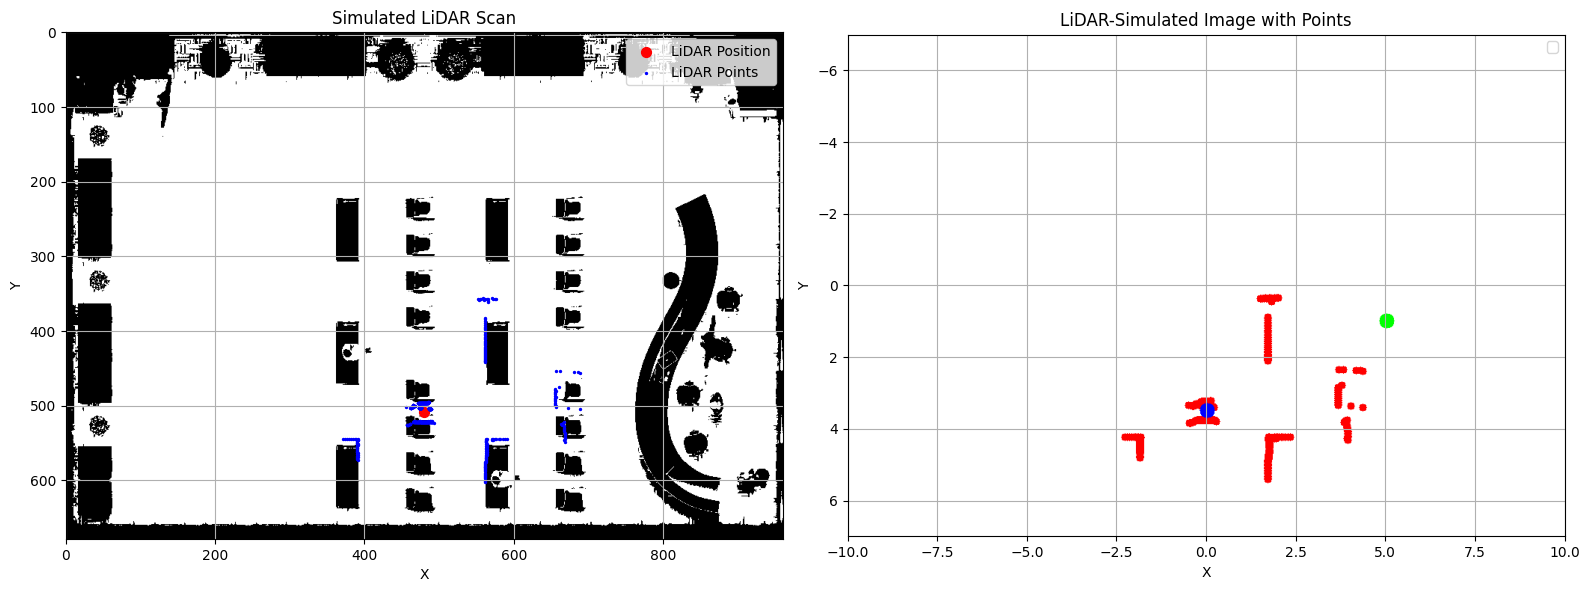

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
def lidar_simulation_from_image(image_path, left_corner, right_corner, start, end, resolution, fov=360, num_rays=720, max_distance=250):
    img = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale
    binary_img = (img > 128).astype(np.uint8)  # Threshold to create a binary map
    binary_img = cv2.resize(binary_img, (0,0), fx=0.25, fy=0.25)
    img_height, img_width = binary_img.shape
    resolution_x = img_width / (right_corner[0] - left_corner[0])
    resolution_y = img_height / (right_corner[1] - left_corner[1])
    distances = []
    lidar_image = np.ones_like(binary_img) * 255  # Initialize a white background for LiDAR image
    def to_image_coords(coord):
        x, y = coord
        img_x = int((x - left_corner[0]) * resolution_x)
        img_y = int((y - left_corner[1]) * resolution_y)  # Correct y-axis scaling and no flipping
        return img_x, img_y
    start_x, start_y = to_image_coords(start)  # LiDAR start
    end_x, end_y = to_image_coords(end)
    # Convert LiDAR image to color for OpenCV drawing
    lidar_image_color = cv2.cvtColor(lidar_image, cv2.COLOR_GRAY2BGR)
    # Simulate LiDAR beams
    angles = np.linspace(0, np.deg2rad(fov), num_rays)
    # Vectorized ray calculations
    for angle in angles:
        dx, dy = np.cos(angle), -np.sin(angle)  # Negate dy to match image coordinates
        distance = 0
        x, y = start_x, start_y
        max_distance = max_distance
        # Move along the ray and check for objects until we exit the image bounds
        while 0 <= x < img_width and 0 <= y < img_height and distance < max_distance:
            if binary_img[int(y), int(x)] == 0:  # Check for an object
                distances.append((distance, angle))
                break  # Found an object, stop the ray
            x += dx * resolution
            y += dy * resolution
            distance += resolution
    # Convert polar coordinates to Cartesian for visualization
    points = [(d * np.cos(a), d * np.sin(a)) for d, a in distances]
    points = np.array(points)
    # Plot the original binary image and LiDAR scan
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    # Plot the simulated LiDAR scan (in binary image)
    axes[0].imshow(binary_img, cmap='gray', extent=(0, img_width, img_height, 0))
    axes[0].scatter(start_x, start_y, color='red', label='LiDAR Position', s=50)
    axes[0].scatter(points[:, 0] / resolution + start_x, points[:, 1] / resolution + start_y, s=2, color='blue', label='LiDAR Points')
    axes[0].legend()
    axes[0].set_title("Simulated LiDAR Scan")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Y")
    axes[0].grid(True)
    # Draw the LiDAR points in the lidar_image using OpenCV
    for point in points:
        lidar_x = int(point[0] / resolution + start_x)
        lidar_y = int(point[1] / resolution + start_y)
        cv2.circle(lidar_image_color, (lidar_x, lidar_y), 5, (255, 0, 0), -1)  # Blue circles for LiDAR points
    # Draw the start and end points
    cv2.circle(lidar_image_color, (start_x, start_y), 10, (0, 0, 255), -1)  # Red circle for start
    cv2.circle(lidar_image_color, (end_x, end_y), 10, (0, 255, 0), -1)  # Green circle for end
    # lidar_image_color = cv2.resize(lidar_image_color, (256, 256))
    # Plot the LiDAR-simulated image with drawn points
    # axes[1].imshow(cv2.cvtColor(lidar_image_color, cv2.COLOR_BGR2RGB), extent=(left_corner[0], right_corner[0], left_corner[1], right_corner[1]))
    axes[1].imshow(lidar_image_color, extent=(left_corner[0], right_corner[0], left_corner[1], right_corner[1]))
    axes[1].set_title("LiDAR-Simulated Image with Points")
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Y")
    axes[1].grid(True)
    axes[1].legend()
    plt.tight_layout()
    plt.show()
    
# Example usage
image_path = "/home/rahm/.local/share/ov/pkg/isaac-sim-4.2.0/standalone_examples/api/omni.isaac.kit/TEST_FILES/New_WR_World.png"  # Replace with the path to your image
resolution = 1  # Distance step in pixels
left = (-10, 7)
right = (10, -7)
start = (0, -3.5)
end = (5, -1)
fov = 360
num_rays = 720
max_distance = 250
lidar_simulation_from_image(image_path, left, right, start, end, resolution, fov, num_rays, max_distance)